[View in Colaboratory](https://colab.research.google.com/github/vovalive/clothes_color_segmentation/blob/master/deeplab_colors_segmentation.ipynb)

First part - module, that is using to create color heatmap, based on KMeans clustering of pixels in RGB space

In [12]:
!pip install ipywidgets
!pip install webcolors==1.3

In [0]:
## Using Kmeans to cluster colors and create cluster map/heatmap

import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class DominantColors:

    CLUSTERS = None
    IMAGE = None
    COLORS = None
    LABELS = None
    
    def __init__(self, image, clusters=3):
        self.CLUSTERS = clusters
        self.IMAGE = image
    
    def dominantColors(self):
    
        #open image
        img = cv2.imread(self.IMAGE)
        img = cv2.resize(img, None ,fx = .1, fy= .1, interpolation = cv2.INTER_CUBIC)
        
        #convert to RGB from BGR
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
        #reshaping to a list of pixels
        img = img.reshape((img.shape[0] * img.shape[1], 3))
        
        #save image after operations
        self.IMAGE = img
        
        #using k-means to cluster pixels
        kmeans = KMeans(n_clusters = self.CLUSTERS, random_state=42)
        kmeans.fit(img)
        
        #getting the colors as per dominance order
        self.COLORS = kmeans.cluster_centers_
        
        #save labels
        self.LABELS = kmeans.labels_
        
        return self.COLORS.astype(int)
                
    def plotHistogram(self):
       
        #labels form 0 to no. of clusters
        numLabels = np.arange(0, self.CLUSTERS+1)
       
        #create frequency count tables    
        (hist, _) = np.histogram(self.LABELS, bins = numLabels)
        hist = hist.astype("float")
        hist /= hist.sum()
        
        #appending frequencies to cluster centers
        colors = self.COLORS
        
        #descending order sorting as per frequency count
        colors = colors[(-hist).argsort()]
        hist = hist[(-hist).argsort()] 
        
        #creating empty chart
        chart = np.zeros((50, 500, 3), np.uint8)
        start = 0
        
        #creating color rectangles
        for i in range(self.CLUSTERS):
            end = start + hist[i] * 500
            
            #getting rgb values
            r = colors[i][0]
            g = colors[i][1]
            b = colors[i][2]
            
            #using cv2.rectangle to plot colors
            cv2.rectangle(chart, (int(start), 0), (int(end), 50), (r,g,b), -1)
            start = end	
        
        #display chart
        plt.figure()
        plt.axis("off")
        plt.imshow(chart)
        plt.show()
        return hist
        
    def rgb_to_hex(self, rgb):
        return '#%02x%02x%02x' % (int(rgb[0]), int(rgb[1]), int(rgb[2]))

In [14]:
######### segmentation part

import collections
import os
#import StringIO
import io
import sys
import tarfile
import tempfile
import urllib

from IPython import display
from ipywidgets import interact
from ipywidgets import interactive
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image , ImageOps

import tensorflow as tf

if tf.__version__ < '1.5.0':
    raise ImportError('Please upgrade your tensorflow installation to v1.5.0 or newer!')

#### get dataset colormap    

import numpy as np

# Dataset names.
_CITYSCAPES = 'cityscapes'
_PASCAL = 'pascal'

# Max number of entries in the colormap for each dataset.
_DATASET_MAX_ENTRIES = {
    _CITYSCAPES: 19,
    _PASCAL: 256,
}


def create_cityscapes_label_colormap():
  """Creates a label colormap used in CITYSCAPES segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.asarray([
      [128, 64, 128],
      [244, 35, 232],
      [70, 70, 70],
      [102, 102, 156],
      [190, 153, 153],
      [153, 153, 153],
      [250, 170, 30],
      [220, 220, 0],
      [107, 142, 35],
      [152, 251, 152],
      [70, 130, 180],
      [220, 20, 60],
      [255, 0, 0],
      [0, 0, 142],
      [0, 0, 70],
      [0, 60, 100],
      [0, 80, 100],
      [0, 0, 230],
      [119, 11, 32],
  ])
  return colormap


def get_pascal_name():
  return _PASCAL


def get_cityscapes_name():
  return _CITYSCAPES


def bit_get(val, idx):
  """Gets the bit value.

  Args:
    val: Input value, int or numpy int array.
    idx: Which bit of the input val.

  Returns:
    The "idx"-th bit of input val.
  """
  return (val >> idx) & 1


def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((_DATASET_MAX_ENTRIES[_PASCAL], 3), dtype=int)
  ind = np.arange(_DATASET_MAX_ENTRIES[_PASCAL], dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= bit_get(ind, channel) << shift
    ind >>= 3

  return colormap


def create_label_colormap(dataset=_PASCAL):
  """Creates a label colormap for the specified dataset.

  Args:
    dataset: The colormap used in the dataset.

  Returns:
    A numpy array of the dataset colormap.

  Raises:
    ValueError: If the dataset is not supported.
  """
  if dataset == _PASCAL:
    return create_pascal_label_colormap()
  elif dataset == _CITYSCAPES:
    return create_cityscapes_label_colormap()
  else:
    raise ValueError('Unsupported dataset.')


def label_to_color_image(label, dataset=_PASCAL):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.
    dataset: The colormap used in the dataset.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  if np.max(label) >= _DATASET_MAX_ENTRIES[dataset]:
    raise ValueError('label value too large.')

  colormap = create_label_colormap(dataset)
  return colormap[label]

# Needed to show segmentation colormap labels
#sys.path.append('utils')
#import get_dataset_colormap


## Select and download models

_MODEL_URLS = {
    'xception_coco_voctrainaug': 'http://download.tensorflow.org/models/deeplabv3_pascal_train_aug_2018_01_04.tar.gz',
    'xception_coco_voctrainval': 'http://download.tensorflow.org/models/deeplabv3_pascal_trainval_2018_01_04.tar.gz',
}

Config = collections.namedtuple('Config', 'model_url, model_dir')

def get_config(model_name, model_dir):
    return Config(_MODEL_URLS[model_name], model_dir)

config_widget = interactive(get_config, model_name=_MODEL_URLS.keys(), model_dir='')
display.display(config_widget)

# Check configuration and download the model

_TARBALL_NAME = 'deeplab_model.tar.gz'

config = config_widget.result

model_dir = config.model_dir or tempfile.mkdtemp()
tf.gfile.MakeDirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model to %s, this might take a while...' % download_path)
urllib.request.urlretrieve(config.model_url, download_path)
print('download completed!')


## Load model in TensorFlow

_FROZEN_GRAPH_NAME = 'frozen_inference_graph'


class DeepLabModel(object):
    """Class to load deeplab model and run inference."""
    
    INPUT_TENSOR_NAME = 'ImageTensor:0'
    OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
    INPUT_SIZE = 513

    def __init__(self, tarball_path):
        """Creates and loads pretrained deeplab model."""
        self.graph = tf.Graph()
        
        graph_def = None
        # Extract frozen graph from tar archive.
        tar_file = tarfile.open(tarball_path)
        for tar_info in tar_file.getmembers():
            if _FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
                file_handle = tar_file.extractfile(tar_info)
                graph_def = tf.GraphDef.FromString(file_handle.read())
                break

        tar_file.close()
        
        if graph_def is None:
            raise RuntimeError('Cannot find inference graph in tar archive.')

        with self.graph.as_default():      
            tf.import_graph_def(graph_def, name='')
        
        self.sess = tf.Session(graph=self.graph)
            
    def run(self, image):
        """Runs inference on a single image.
        
        Args:
            image: A PIL.Image object, raw input image.
            
        Returns:
            resized_image: RGB image resized from original input image.
            seg_map: Segmentation map of `resized_image`.
        """
        width, height = image.size
        resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
        target_size = (int(resize_ratio * width), int(resize_ratio * height))
        resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
        batch_seg_map = self.sess.run(
            self.OUTPUT_TENSOR_NAME,
            feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
        seg_map = batch_seg_map[0]
        return resized_image, seg_map

model = DeepLabModel(download_path)


## Helper methods

LABEL_NAMES = np.asarray([
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle',
    'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog',
    'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa',
    'train', 'tv'
])

FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)


def vis_segmentation(image, seg_map):
    plt.figure(figsize=(15, 5))
    grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('input image')
    
    plt.subplot(grid_spec[1])
    seg_image = label_to_color_image(
        seg_map, get_pascal_name()).astype(np.uint8)
    plt.imshow(seg_image)
    plt.axis('off')
    plt.title('segmentation map')

    plt.subplot(grid_spec[2])
    plt.imshow(image)
    plt.imshow(seg_image, alpha=0.7)
    plt.axis('off')
    plt.title('segmentation overlay')
    
    unique_labels = np.unique(seg_map)
    ax = plt.subplot(grid_spec[3])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0)
    
    plt.show()

## Run on sample images

# Note that we are using single scale inference in the demo for fast
# computation, so the results may slightly differ from the visualizations
# in README, which uses multi-scale and left-right flipped inputs.

IMAGE_DIR = ''

def run_demo_image(image_name):
    try:
        image_path = os.path.join(IMAGE_DIR, image_name)
        orignal_im = Image.open(image_path)
    except IOError:
        print('Failed to read image from %s.' % image_path)
        return 
    print('running deeplab on image %s...' % image_name)
    resized_im, seg_map = model.run(orignal_im)
    
    vis_segmentation(resized_im, seg_map)


## Run on internet images

def get_an_internet_image(url):
    if not url:
        return

    try:
        # Prefix with 'file://' for local file.
        if os.path.exists(url):
            url = 'file://' + url
        f = urllib.request.urlopen(url)
        jpeg_str = f.read()
    except IOError:
        print('invalid url: ' + url)
        return

    orignal_im = Image.open(io.BytesIO(jpeg_str))
    print('running deeplab on image %s...' % url)
    resized_im, seg_map = model.run(orignal_im)
    
    vis_segmentation(resized_im, seg_map)

#_ = interact(get_an_internet_image, url='https://avatars.mds.yandex.net/get-pdb/753890/68b9151b-e391-4100-b6cc-548ed5652985/s1200')

def segment_the_file(jpegfile):
    print('running deeplab on image %s...')
    resized_im, seg_map = model.run(jpegfile)
    print('gotovo')
    return resized_im, seg_map

downloading model to /tmp/tmpdmo_svf0/deeplab_model.tar.gz, this might take a while...
download completed!


In [15]:
## loading dataset as pandas dataframe
import pandas as pd
imgs=pd.read_csv("http://vovalive.ru/sample_products_llist.tsv",delimiter="\t")
imgs.head()

,Colour,Category,Img 1
0,Blue,Dress,https://glodimg.chinabrands.com/pdm-product-pi...
1,Grey,Dress,https://glodimg.chinabrands.com/pdm-product-pi...
2,Black,Dress,https://glodimg.chinabrands.com/pdm-product-pi...
3,Black,Dress,https://glodimg.chinabrands.com/pdm-product-pi...
4,Blue,Dress,https://glodimg.chinabrands.com/pdm-product-pi...


Now some code using Keras pre-trained model for image classification.
It downloads MobileNet model, runs the model on image and returns top 7 predictions of the model

In [16]:
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential, Model Fcat
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping

img_width, img_height = 128, 128

model_classify = applications.MobileNet(weights = "imagenet", include_top=True, input_shape = (img_width, img_height, 3))
#print(model_classify.summary())

SyntaxError: ignored

In [0]:
## to create colour name

import webcolors

def closest_colour(requested_colour):
    min_colours = {}
    for key, name in webcolors.css3_hex_to_names.items():
        r_c, g_c, b_c = webcolors.hex_to_rgb(key)
        rd = (r_c - requested_colour[0]) ** 2
        gd = (g_c - requested_colour[1]) ** 2
        bd = (b_c - requested_colour[2]) ** 2
        min_colours[(rd + gd + bd)] = name
    return min_colours[min(min_colours.keys())]
  

#closest_colour(tuple(colors[3]))

In [127]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from skimage.transform import resize
import PIL
from PIL import Image , ImageOps
import numpy
import matplotlib.pyplot as plt
from urllib.request import urlopen

#pic = load_img(pathtophotos+picfiles[1])  # this is a Numpy array with shape (3, 150, 150)

## select image from table
#imageurl=imgs['IMG-1'][11]
imageurl=''
imageurl='http://202.83.16.3:81/images/acedrop/FLK/FUED/YADKINVILLE46_1.jpg'
## load image 
pic = PIL.Image.open(urlopen(imageurl))

## segment from background
resized_im, seg_map = segment_the_file(pic)
mask=Image.fromarray((seg_map*255).astype('uint8'),mode='L')
nobkg = resized_im
nobkg.putalpha(mask)
nobkg.save('nobkg.png')

#pic=Image.open('nobkg.png')

x = numpy.array(pic)
print(x.shape)
x = resize(x,(128,128))
x = x.reshape((1,) + x.shape) 

#%time impredict=intermediate_layer_model.predict(x)
%time prediction=model_classify.predict(x)

plt.plot(prediction.flatten())
plt.show()
#plt.plot(impredict.flatten())
#plt.show()

running deeplab on image %s...
gotovo
(1440, 1080, 3)


/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


NameError: ignored


# Image can be changed here:

##  imageurl=imgs['Img 1'][111]
change 111 to any number from 0 to 999

In [128]:
from keras.applications.mobilenet import decode_predictions
from PIL import Image
print(decode_predictions(prediction, top=7)[0])
pic.resize((300,300),Image.ANTIALIAS)

NameError: ignored

Next step is to run clustering and heatmap production

[[ 80 107  96]
 [250 250 249]
 [ 27  35  28]
 [172 158 143]
 [ 50  71  60]]


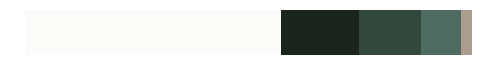

[ 80 107  96] dimgrey      fraction =  0.5737874097007224
[250 250 249] snow      fraction =  0.17595459236326108
[27 35 28] black      fraction =  0.13725490196078433
[172 158 143] rosybrown      fraction =  0.0892672858617131
[50 71 60] darkslategrey      fraction =  0.023735810113519093


In [129]:
image='nobkg.png'

# number of dominant colors
clusters = 5

dc = DominantColors(image, clusters)

colors = dc.dominantColors()
print(colors)

#dc.plotClusters()

h = dc.plotHistogram()

for i,c in enumerate(colors):
    print(c, closest_colour(tuple(c)),'     fraction = ', h[i])

In [0]:
# remove background
imarray=numpy.array(resized_im)
(np.mod(imarray, 4)==0).any(2)
imarray=imarray[~(np.mod(imarray, 4)==0).any(2)]
imarray=np.delete(imarray,3,1)

In [0]:
## Using Kmeans to cluster colors and create cluster map/heatmap
## VERSION using Array as input, not Image

import cv2
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class array_DominantColors:

    CLUSTERS = None
    IMAGE = None
    COLORS = None
    LABELS = None
    
    def __init__(self, image, clusters=3):
        self.CLUSTERS = clusters
        self.IMAGE = image
    
    def dominantColors(self):
    
        #open image
       # img = cv2.imread(self.IMAGE)
       # img = cv2.resize(img, None ,fx = .1, fy= .1, interpolation = cv2.INTER_CUBIC)
        
        #convert to RGB from BGR
       # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
        #reshaping to a list of pixels
        img = self.IMAGE
        
        #save image after operations
        #self.IMAGE = img
        
        #using k-means to cluster pixels
        kmeans = KMeans(n_clusters = self.CLUSTERS, random_state=42)
        kmeans.fit(img)
        
        #getting the colors as per dominance order
        self.COLORS = kmeans.cluster_centers_
        
        #save labels
        self.LABELS = kmeans.labels_
        
        return self.COLORS.astype(int)
                
    def plotHistogram(self):
       
        #labels form 0 to no. of clusters
        numLabels = np.arange(0, self.CLUSTERS+1)
       
        #create frequency count tables    
        (hist, _) = np.histogram(self.LABELS, bins = numLabels)
        hist = hist.astype("float")
        hist /= hist.sum()
        
        #appending frequencies to cluster centers
        colors = self.COLORS
        
        #descending order sorting as per frequency count
        colors = colors[(-hist).argsort()]
        hist = hist[(-hist).argsort()] 
        
        #creating empty chart
        chart = np.zeros((50, 500, 3), np.uint8)
        start = 0
        
        #creating color rectangles
        for i in range(self.CLUSTERS):
            end = start + hist[i] * 500
            
            #getting rgb values
            r = colors[i][0]
            g = colors[i][1]
            b = colors[i][2]
            
            #using cv2.rectangle to plot colors
            cv2.rectangle(chart, (int(start), 0), (int(end), 50), (r,g,b), -1)
            start = end	
        
        #display chart
        plt.figure()
        plt.axis("off")
        plt.imshow(chart)
        plt.show()
        return hist
        
    def rgb_to_hex(self, rgb):
        return '#%02x%02x%02x' % (int(rgb[0]), int(rgb[1]), int(rgb[2]))

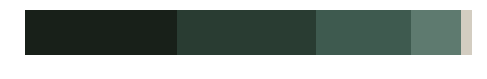

[41 60 50] darkslategrey      fraction =  0.3418856147481492
[23 31 24] black      fraction =  0.30817244883147044
[210 205 193] lightgrey      fraction =  0.21479895485556685
[ 93 121 111] dimgrey      fraction =  0.11166352155610393
[62 90 79] darkslategrey      fraction =  0.023479460008709537


In [132]:
if len(imarray) == 0:
  print("Segmentation resulting empty image")
else:
  # number of dominant colors
  clusters = 5
  dc = array_DominantColors(imarray, clusters)
  colors = dc.dominantColors()
  #print(colors)
  #dc.plotClusters()
  h = dc.plotHistogram()
  for i,c in enumerate(colors):
    print(c, closest_colour(tuple(c)),'     fraction = ', h[i])

# Cool links
https://github.com/ayushoriginal/Optimized-RGB-To-ColorName

https://www.materialui.co/colors

Model for segmentation:
https://github.com/anish9/Fashion-AI-segmentation


Segmentation results:


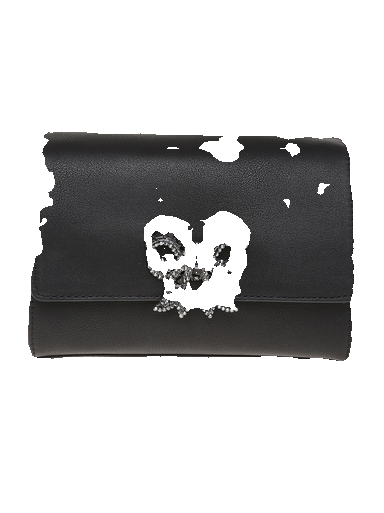

In [78]:
print('Segmentation results:')
resized_im

In [53]:
h

array([0.60553633, 0.1987697 , 0.09265667, 0.06843522, 0.03460208])